In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\train.csv", parse_dates=['timestamp'])
test =  pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\test.csv", parse_dates=['timestamp'])
macro = pd.read_csv("C:\\Users\\user\\AnacondaProjects\\Sberbank\\macro.csv", parse_dates=['timestamp'])

In [3]:
#selecting only important macro columns
macro = macro[["timestamp","balance_trade","balance_trade_growth","eurrub","average_provision_of_build_contract","micex_rgbi_tr","micex_cbi_tr","deposits_rate","mortgage_value","mortgage_rate","income_per_cap","rent_price_4+room_bus","museum_visitis_per_100_cap","apartment_build"]]

y_train = train['price_doc']
id_test = test['id']

train.drop(['id', 'price_doc'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

# Build all_data = (train+test).join(macro)
num_train = len(train)
all_data = pd.concat([train, test])
all_data = all_data.join(macro, on='timestamp', rsuffix='_macro')

In [4]:
# Creating Apartment Name Feature
all_data['apartment_name'] = pd.factorize(all_data.sub_area + all_data['metro_km_avto'].astype(str))[0]

#cleaning of full_sq
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"]))),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data["life_sq"]>=6) & (all_data["life_sq"]<300) & ((all_data["full_sq"]>= all_data["life_sq"]*15) | ((all_data["full_sq"]>=0) & (all_data["full_sq"]<all_data["life_sq"])))].life_sq
g_Apartment_col=all_data.groupby('apartment_name')['full_sq'].agg(['mean','median','count']).reset_index()
g_Apartment_col.columns= ['apartment_name','full_sq_mean','full_sq_median','apartment_count'] 
all_data=all_data.merge(g_Apartment_col, how='left')
all_data.loc[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3),"full_sq"]=all_data[((all_data["full_sq"]<=6) | (all_data["full_sq"]>300)) & (all_data.apartment_count>3)].full_sq_mean

all_data.drop("full_sq_median", axis=1, inplace=True)
all_data.drop("full_sq_mean", axis=1, inplace=True)

# Remove timestamp column (may overfit the model in train)
all_data.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)


In [5]:
# cleaning price_doc
train = all_data[:num_train]
test  = all_data[num_train:]

In [6]:
train = pd.concat((train,y_train),axis=1)
train["prize_per_sqrmtr"]=train.price_doc/train.full_sq

In [7]:
train[["full_sq","life_sq","floor","max_floor","material","build_year","num_room","kitch_sq","state","sub_area","price_doc","prize_per_sqrmtr"]].head(10)

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,prize_per_sqrmtr
0,43.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Bibirevo,5850000,136046.511628
1,34.0,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,Nagatinskij Zaton,6000000,176470.588235
2,43.0,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,Tekstil'shhiki,5700000,132558.139535
3,89.0,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Mitino,13100000,147191.011236
4,77.0,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Basmannoe,16331452,212096.779221
5,67.0,46.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,Nizhegorodskoe,9100000,135820.895522
6,25.0,14.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,Sokol'niki,5500000,220000.000000
7,44.0,44.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Bibirevo,2000000,45454.545455
8,42.0,27.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Koptevo,5300000,126190.476190
9,36.0,21.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Kuncevo,2000000,55555.555556


In [8]:
# grouping by price_doc
g_Apartment_col=train.groupby('apartment_name')['prize_per_sqrmtr'].agg(['mean','std']).reset_index()
g_Apartment_col.columns= ['apartment_name','pps_mean','pps_std'] 
train=train.merge(g_Apartment_col, how='left')

In [9]:
train[(train.prize_per_sqrmtr > train.pps_mean + (4*train.pps_std)) | (train.prize_per_sqrmtr < train.pps_mean - (4*train.pps_std))][["full_sq","life_sq","floor","max_floor","material","build_year","num_room","kitch_sq","state","sub_area","price_doc","prize_per_sqrmtr","metro_km_avto"]]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,sub_area,price_doc,prize_per_sqrmtr,metro_km_avto
3735,22.000000,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,Poselenie Moskovskij,4637566,210798.454545,6.732362
7488,43.000000,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,Poselenie Sosenskoe,4579200,106493.023256,5.093223
10262,110.000000,NaN,16.0,1.0,1.0,NaN,2.0,1.0,NaN,Tverskoe,29040000,264000.000000,1.036568
10325,29.000000,29.0,16.0,16.0,4.0,2013.0,1.0,1.0,1.0,Chertanovo Central'noe,13336080,459864.827586,0.685945
11741,101.000000,65.0,17.0,22.0,4.0,1995.0,4.0,10.0,3.0,Mitino,1000000,9900.990099,0.695893
12862,79.000000,NaN,6.0,0.0,1.0,NaN,2.0,0.0,NaN,Tverskoe,29047260,367686.835443,1.036568
14637,62.000000,36.0,1.0,5.0,2.0,1956.0,2.0,7.0,NaN,Ochakovo-Matveevskoe,8500000,137096.774194,3.161749
15239,69.000000,39.0,6.0,8.0,2.0,1917.0,3.0,7.0,3.0,Tverskoe,18800000,272463.768116,1.036568
16284,33.000000,62.0,2.0,10.0,1.0,2014.0,2.0,1.0,1.0,Poselenie Krasnopahorskoe,3759912,113936.727273,25.703575
16743,149.054545,NaN,32.0,32.0,1.0,NaN,6.0,0.0,NaN,Obruchevskoe,54212936,363712.061478,2.070597


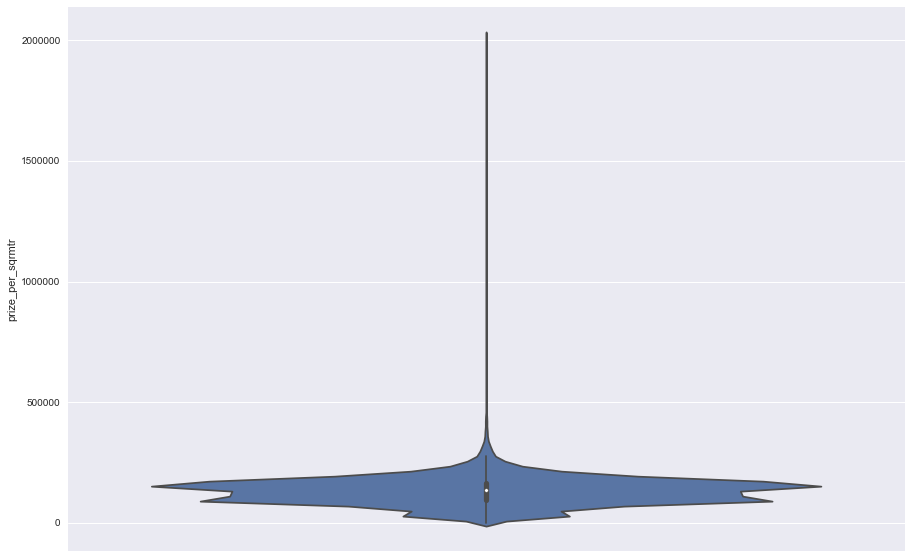

In [10]:
import seaborn as sns
fig, axis1 = plt.subplots(1,1,figsize=(15,10))
fig = sns.violinplot(y="prize_per_sqrmtr", data=train)

In [11]:
train.prize_per_sqrmtr.quantile(0.01)

18418.181818181816

In [12]:
train.prize_per_sqrmtr.quantile(0.99999)

1617936.4758876553

In [14]:
train[train.price_doc.isin([1000000,2000000,3000000])]

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,income_per_cap,rent_price_4+room_bus,museum_visitis_per_100_cap,apartment_build,apartment_name,apartment_count,price_doc,prize_per_sqrmtr,pps_mean,pps_std
7,44.0,44.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,7,4,2000000,45454.545455,107656.756242,53947.172464
9,36.0,21.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,9,5,2000000,55555.555556,106085.737179,76940.070557
39,33.0,18.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,39,2,2000000,60606.060606,53030.303030,10713.739109
50,51.0,33.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,37,7,1000000,19607.843137,152027.629234,75979.382938
56,56.0,39.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,55,1,2000000,35714.285714,35714.285714,NaN
66,50.0,29.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,65,1,1000000,20000.000000,20000.000000,NaN
68,76.0,45.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,66,2,2000000,26315.789474,100995.732575,105613.388371
80,47.0,31.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,78,4,1000000,21276.595745,80055.161545,66491.564275
82,34.0,19.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,80,2,1000000,29411.764706,93277.310924,90319.521631
107,74.0,43.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,Investment,...,NaN,NaN,NaN,NaN,105,4,1000000,13513.513514,74061.295607,63308.458747
